In [2]:
from pylab import *
from brian2 import *
import time

In [3]:
%matplotlib inline

plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'font.family': 'serif', 
                     'font.serif':['Computer Modern']})

# The Hodgkin Huxley Paradigm

There is no nobel prize in neuroscience, but occasionally a neuroscientist will win the prize in physiology and medicine (sometimes in chemistry or physics). 
The field of computational neuroscience claims only a few nobel prize winners, one of which were the scientific duo of Hodgkin and Huxley. 

In the lead-up to their nobel prize-winnning work, Neuroscientists were recording the electrical activity of nerves and muscles. They were starting to understand that behavior was driven by electrical impulses, "spikes", that they could literally hear in their recordings -- by playing recordings on a speaker, electrophysiologists could listen to their recordings and recognize many important features.

In the late 1930s and early 1940s, electronics technology was just beginning to take-off. 

## Neuroscience Bootcamp

When I was a grad student at UCSD we would teach entering Neuroscience Ph.D. students a course called "bootcamp". 
In this course, students would dive into the art of electrophysiology in a two week, 8am-midnight including Saturdays immersive experience. 

Electrophysiology is one of the primary techniques for studying the brain, and to perform electrophysiology you must understand the basics of electronics. 
And so, in the very first lesson of boot camp we actually do some work with electrical circuits. 

When you try to record from a neuron, you model the neuron as an electrical circuit. The salty ionic solution that surrounds biological tissue conducts electricity. While the fact that in this medium electricity moves through charged ions rather than through electrons, the rules of electrodynamics are largely the same.

Maxwell's equations are thus the tools of the trade. Ohm's law, capacitance, these are the physical rules used to describe neurons in the brain. 




## Hodgkin Huxley 1949d

In a series of 4 papers, HH laid the foundations of computational neuroscience. 

From their own perspective, their work was "curve fitting", and they original did not foresee the impact that it had. How ironic, the authors dismiss their own work that wins the nobel prize. 

With their new technique of voltage clamp, HH were able to record from the squid giant axon. They used different solutions containing different ions as well as a chemical called tetrodotoxin.

They could then record the responses of the squid giant axon and isolate the particular currents moving across the membrane. 

This soon lead them to furhter develop the electronic model of the neuron. 

![Hodgkin1.png](figures/Hodgkin1.png)

Along with the typical RC circuit of the membrane (indicated by the capacitor and leak conductance $g_l$), HH defined a set of "channels" through which ionic currents were regulated. 

The idea is that these channels would allow for a particular ion to pass through, and they opened and closed dependent on the voltage of across the membrane and internal dynamics. 

## Goldman-Hodgkin-Katz

First, lets talk about ionic currents. Like electrons, ion have charge and when dissolved in solution can conduct electricity. Thus they can be the medium for electronic circuit dynamics governed by maxwell's equations. Largely, Maxwell's equations are a sufficient approximation of the flow of electricity with ions.

One important aspect of ions, however, is that their movement is not only governed by electrical forces, but also depends on ionic concentrations. Essentially statistical mechanics and diffusion also appears as a force that pushes and pulls ions like the electrical forces. 

Thus overall, the dynamics of ions are determined by both electrical forces and relative concentrations, summarized by the GHK equations:

$$
E = V \log([In]/[Out])
$$

In essence this equation says that the driving force of an ionic current is dependent on the voltage (and charge of ion) as well as the relative concentrations of that particular ion inside and outside of the membrane.

There are a few primary ions that biology uses, sodium potassium and chlorine (but of course there are even more). Biology primarily evolved in salt-water, very rich in sodium and chlorine ions. However, inside of cells is relatively low concentrations of sodium, but relatively high concentrations of potassium. There are actually proteins that pump out sodium from inside the cell, and pump in potassium, and this is how neurons in the brain achieve their membrane potentials. 

While the GHK equation governs the driving force of the ionic currents. For many of the ionic currents used in neurons there is a simple approximation. The idea behind this approximation is that although ions are moving across the membrane during the action-potential, the concentrations of ions really does not change so drastically. Especially considering the logarithmic relationship in the GHK equations, it is often possible to ignore the subtle effect of the concentrations changing when computing the driving force of the ion. Under this approximation, the concentration term of the GHK equation can be replaced by a simple "reversal potential". Since the concentrations do not change much during the dynamics, there is a voltage level at which the driving force switches, i.e. the current reverses direction. 

The reversal potential for sodium (in a typical neuron), which is positively charged, is around +20mV. This means that if the membrane potential of the cell was greater than +20mV, then sodium would move out of the cell, otherwise sodium would move into the cell. The resting potential of a neuron is typically quite negative, -50mV to -80mV. Sodium is also much more concentrated outside of the cell than inside. Thus when the cell is at its resting potential, both the voltage and concentration drive sodium ions into the cell.

The potassium ion has much the opposite experience. Potassium is also positively charged, and so the electrical force wants to drive the ions to inside of the cell, but the concentration of potassium is high inside the cell and low outside of the cell. This results in the reversal potential for potassium being around -80mV, and so potassium will only go into the cell if the membrane potential is even lower than -80mV. 

These two ions are the primary factors for the action-potential. Sodium rushes into the cell to increase the internal membrane potential. Potassium rushes out of the cell to decrease the membrane potential. In the background, the sodium-potassium pump is constantly trying to maintain the ionic balance so that the neuron can operate. 

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern


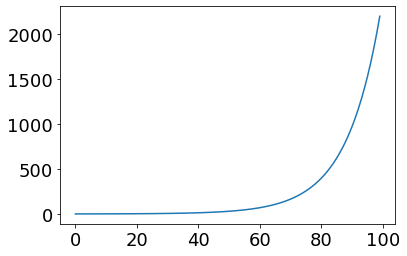

In [6]:
plot(exprel(linspace(0, 10, 100)))

WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]


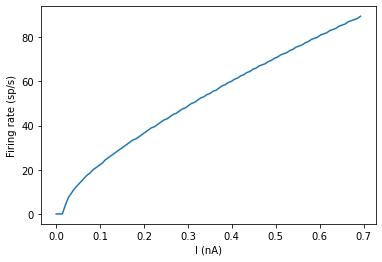

In [1]:
from brian2 import *

num_neurons = 100
duration = 2*second

# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
gl = 5e-5*siemens*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = 100*msiemens*cm**-2 * area
g_kd = 30*msiemens*cm**-2 * area
VT = -63*mV

# The model
eqs = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*4*mV/exprel((13.*mV-v+VT)/(4*mV))/ms*(1-m)-0.28*(mV**-1)*5*mV/exprel((v-VT-40.*mV)/(5*mV))/ms*m : 1
dn/dt = 0.032*(mV**-1)*5*mV/exprel((15.*mV-v+VT)/(5*mV))/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp
''')
# Threshold and refractoriness are only used for spike counting
group = NeuronGroup(num_neurons, eqs,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El
group.I = '0.7*nA * i / num_neurons'

monitor = SpikeMonitor(group)

run(duration)

plot(group.I/nA, monitor.count / duration)
xlabel('I (nA)')
ylabel('Firing rate (sp/s)')
show()